# Particle Swarm Optimisation 

reference: https://medium.com/@adamprice97/the-cartepole-problem-competitive-performance-with-particle-swarm-optimization-672f018ede3c

## Imports

In [1]:
import gym
from gym import envs
import numpy as np
import time
from numpy import savetxt

In [2]:
def saveweights(solver):
    savetxt('PSO_weights.csv', solver.bestGlobalPos, delimiter=',')

In [3]:
def relu(X):
    return np.maximum(0,X)

## Create optimiser

This is a standard version of PSO. It could be improved with parameters tunning, similar to that seen in learning rate optimisers. 

In [4]:
class ParticleSwarmOptimisation(object):
    
    def __init__(self, fitnessFunction, bounds, numParticles, omega, v, phiL, phiG):
        self.bestGlobalFitness = -np.inf              
        self.bestGlobalPos = []     
        self.fitnessFunction = fitnessFunction
        self.bounds = bounds 
        self.swarm = [] #Create swarm
        for i in range(numParticles):
            self.swarm.append(Particle(bounds, omega, v, phiL, phiG))

    def maxamise(self, maxIterations, target):
#         bestGlobalFitness = -np.inf              
#         bestGlobalPos = []                
        #Optimisation loop
        for i in range(1, maxIterations):
            #Evaluate each particles fitness
            for p in self.swarm:
                fitness = p.evaluate(self.fitnessFunction)
                #Determine if current particle is new global best
                if fitness > bestGlobalFitness:
                    bestGlobalPos = p.bestPos.copy()
                    bestGlobalFitness = p.bestFitness
            #Update velocity and positions
            for p in self.swarm:
                p.updateVelocity(bestGlobalPos)
                p.updatePosition(self.bounds)     
            #Resample best to see if environment is solved
            bestGlobalFitness = self.fitnessFunction(bestGlobalPos, 100)
            print('Iteration: ' + str(i) + ' Global best: ' + str(bestGlobalFitness))
            if bestGlobalFitness > target:
                return i
        return i #failed to solve

class Particle:
    def __init__(self, bounds, omega, v, phiL, phiG):
        self.bestFitness = -np.inf     
        self.bestPos = []
        self.omega, self.phiL, self.phiG  = omega, phiL, phiG

        self.position =  np.random.uniform(low=bounds[0], high=bounds[1], size=8)
        self.velocity = np.random.uniform(low=-v, high=v, size=8)

    # evaluate current fitness
    def evaluate(self, fitnessFunction):
        fitness = fitnessFunction(self.position, 25)
        #update best position
        if fitness > self.bestFitness:
            self.bestPos = self.position.copy()
            self.bestFitness = fitness
        else:
            #Re-evaluate best 
            self.bestFitness = fitnessFunction(self.bestPos, 25)
        return self.bestFitness
                    
    # update new particle velocity
    def updateVelocity(self, globalBest):
        velLocal= self.phiL * np.random.rand((len(self.bestPos))) * (self.bestPos - self.position)
        velGlobal = self.phiG * np.random.rand((len(self.bestPos))) * (globalBest - self.position)
        self.velocity = self.omega * self.velocity + velLocal + velGlobal

    # update the particle position 
    def updatePosition(self,bounds):  
        self.position = self.position + self.velocity            
        self.position[self.position < bounds[0]] = bounds[0]
        self.position[self.position > bounds[1]] = bounds[1]        

## Create Fitness Function

The particles position is used as the weights in a linear layer which is past through a softmax fuction to create a stochastic policy.

Note the need for repeated sampling of the environment to get a good estimate of the policy.

In [5]:
class CartpoleFitness(object):

    def __init__(self, terminationStep):
        self.env = gym.make('CartPole-v1')
        self.terminationStep = terminationStep

    def policy(self, state, pos):
        z = state.dot(pos)
        exp = np.exp(z)
        return exp/np.sum(exp)

    def evaluate(self, pos, evaluationIterations):
        policy = np.reshape(pos, (4,2))
        rewardTotal = 0
        for i in range(evaluationIterations):
            state = self.env.reset()
            step = 0
            while True:
                step += 1
                probs = self.policy(state, policy)
                action = np.random.choice(2,p=probs)
                state, reward, terminal, _ = self.env.step(action)
                rewardTotal += reward
                if terminal or step > self.terminationStep:
                    break

        return rewardTotal  / (i+1)

Current Policy

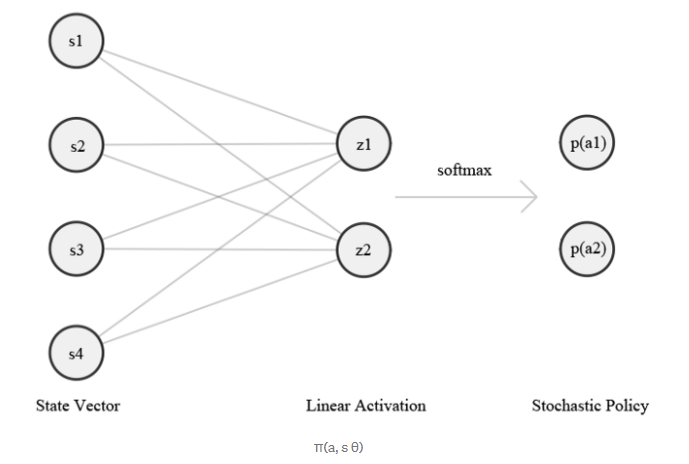

## Create experiment

Change optimiser parameters here

In [ ]:
cartpole = CartpoleFitness(200)

weightSpaceBounds = 8
numberOfParticles = 15
momentum = 0.5
initialVelocityBounds = 0.25
localWeight = 2
globalWeight = 2

p = [weightSpaceBounds, numberOfParticles, momentum, initialVelocityBounds, localWeight, globalWeight]

timeTotal = 0
iterationTotal = 0
for i in range(1, 11):
    start = time.time()
    solver = ParticleSwarmOptimisation(cartpole.evaluate, (-p[0],p[0]), p[1], p[2], p[3], p[4], p[5])
    k = solver.maxamise(25, 195)
    iterationTotal += k
    end = time.time() - start
    print('Trail ' + str(i) + ' solved in ' + str(k) + ' iterations and ' + "{:.1f}".format(end) + ' seconds.')
    timeTotal += end
print('Solved in an average of ' + str(iterationTotal/i) + ' iterations, with an average of ' + "{:.1f}".format(timeTotal /i) + ' seconds per trail.')

We can see that the cartpole problem is solved in an average of 2.4 iterations, with an average of 8.3 seconds per trail. This average time could be greatly improved with the use of parallel computation and better hardware.

The iteration average is very impressive, but we need to keep in mind the swarm used. In a standard RL implementation, a single agent is used, it can only run a single episode each iteration. Our swarm effectively runs 15 episodes each iteration and so, in a fair comparison between the swarm and a single agent, we would let the single-agent run for 15 times more episodes. 

The counter-argument to this is the single-agent requiring far more computation than a single swarm agent. In the case of a DNN implementation, there could be 1000s of weights being updated each time step. In contrast, our swarm is optimising 180 (12*15) weights between episodes. 

In close this out, I want get a little bit preachy.

Often, in cartpole solving implementations, episodes will terminate after 500 steps (this being the limit built into the environment.) This is wrong. The solve task is considered solved after averaging >= 195 reward over 100 episodes while terminating after the 200th episode. This ensures that the solution is consistently solving the problem, which is a more difficult task than beating the 195 average when episodes can last far longer. 

To illustrate this point, I will rerun the previous experiment, but with a 500 episode limit.

In [ ]:
cartpole = CartpoleFitness(500)

timeTotal = 0
iterationTotal = 0
for i in range(1, 11):
    start = time.time()
    solver = ParticleSwarmOptimisation(cartpole.evaluate, (-p[0],p[0]), p[1], p[2], p[3], p[4], p[5])
    k = solver.maxamise(25, 195)
    iterationTotal += k
    end = time.time() - start
    print('Trail ' + str(i) + ' solved in ' + str(k) + ' iterations and ' + "{:.1f}".format(end) + ' seconds.')
    timeTotal += end
print('Solved in an average of ' + str(iterationTotal/i) + ' iterations, with an average of ' + "{:.1f}".format(timeTotal /i) + ' seconds per trail.')

We see the average solve iterations has dropped to 1.7. Clearly, the problem has been made easier but raising the episode limit.


# GMM Model

In [6]:
import gym
from machine import Machine
from GymMachEnv import MachineEnv

machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [ ]:
class ParticleSwarmOptimisationGMM(object):
    
    def __init__(self, fitnessFunction,policy, bounds, numParticles, omega, v, phiL, phiG):
        self.bestGlobalFitness = -np.inf              
        self.bestGlobalPos = []     
        self.fitnessFunction = fitnessFunction
        self.policy = policy
        self.bounds = bounds 
        self.swarm = [] #Create swarm
        for i in range(numParticles):
            self.swarm.append(Particle(bounds, omega, v, phiL, phiG))

    def maxamise(self, maxIterations, target):
        GlobalFitness = -np.inf              
        GlobalPos = []                
        #Optimisation loop
        for i in range(1, maxIterations):
            #Evaluate each particles fitness
            for p in self.swarm:
                fitness = p.evaluate(self.fitnessFunction)
                #Determine if current particle is new global best
                if fitness > self.bestGlobalFitness:
                    self.bestGlobalPos = p.bestPos.copy()
                    self.bestGlobalFitness = p.bestFitness
            #Update velocity and positions
            for p in self.swarm:
                p.updateVelocity(self.bestGlobalPos)
                p.updatePosition(self.bounds)     
            #Resample best to see if environment is solved
            Fitness = self.fitnessFunction(self.bestGlobalPos, 100)
            print('Iteration: ' + str(i) + ' Global best: ' + str(Fitness))
            if Fitness > target:
                return i
        return i #failed to solve
    
    def predict(self,state):
        pos = np.reshape(self.bestGlobalPos, (4,2))
        prob = self.policy(state, pos)
        return np.random.choice(2,p=prob) 

class Particle:
    def __init__(self, bounds, omega, v, phiL, phiG):
        self.bestFitness = -np.inf     
        self.bestPos = []
        self.omega, self.phiL, self.phiG  = omega, phiL, phiG

        self.position =  np.random.uniform(low=bounds[0], high=bounds[1], size=8)
        self.velocity = np.random.uniform(low=-v, high=v, size=8)

    # evaluate current fitness
    def evaluate(self, fitnessFunction):
        fitness = fitnessFunction(self.position, 25)
        #update best position
        if fitness > self.bestFitness:
            self.bestPos = self.position.copy()
            self.bestFitness = fitness
        else:
            #Re-evaluate best 
            self.bestFitness = fitnessFunction(self.bestPos, 25)
        return self.bestFitness
                    
    # update new particle velocity
    def updateVelocity(self, globalBest):
        velLocal= self.phiL * np.random.rand((len(self.bestPos))) * (self.bestPos - self.position)
        velGlobal = self.phiG * np.random.rand((len(self.bestPos))) * (globalBest - self.position)
        self.velocity = self.omega * self.velocity + velLocal + velGlobal

    # update the particle position 
    def updatePosition(self,bounds):  
        self.position = self.position + self.velocity            
        self.position[self.position < bounds[0]] = bounds[0]
        self.position[self.position > bounds[1]] = bounds[1]        

In [ ]:
class GMMFitness(object):

    def __init__(self, machine):
        self.env = machine

    def policy(self, state, pos):
        z = state.dot(pos)
        exp = np.exp(z)
        return exp/np.sum(exp)

    def evaluate(self, pos, evaluationIterations):
        policy = np.reshape(pos, (4,2))
        rewardTotal = 0
        for i in range(evaluationIterations):
            state = self.env.reset()
            step = 0
            done = False
            while not done:
                step += 1
                probs = self.policy(state, policy)
                action = np.random.choice(2,p=probs)
                state, reward, done, _ = self.env.step(action)
                rewardTotal += reward

        return rewardTotal  / evaluationIterations

New Target is 30k of rewards per episode

In [ ]:
GMM = GMMFitness(env)

weightSpaceBounds = 8
numberOfParticles = 50
momentum = 0.5
initialVelocityBounds = 0.25
localWeight = 2
globalWeight = 2

p = [weightSpaceBounds, numberOfParticles, momentum, initialVelocityBounds, localWeight, globalWeight]

timeTotal = 0
iterationTotal = 0
for i in range(1, 6):
    start = time.time()
    solver = ParticleSwarmOptimisationGMM(GMM.evaluate,GMM.policy,(-p[0],p[0]), p[1], p[2], p[3], p[4], p[5])
    k = solver.maxamise(10, 30000)
    iterationTotal += k
    end = time.time() - start
    print('Trail ' + str(i) + ' solved in ' + str(k) + ' iterations and ' + "{:.1f}".format(end) + ' seconds.')
    timeTotal += end
print('Solved in an average of ' + str(iterationTotal/i) + ' iterations, with an average of ' + "{:.1f}".format(timeTotal /i) + ' seconds per trail.')

# Testing

In [ ]:
state = env.reset()

In [ ]:
for _ in range(50):
    action = solver.predict(state)
    state, reward, done, _ = env.step(action)
    print("State:",env.state,"Action:",action, "Reward:",reward)

In [ ]:
env.step(1)
env.state

In [ ]:
for _ in range(20):
    s = env.sensor()
    action = solver.predict(s)
    print(action)

In [ ]:
solver.bestGlobalPos

In [ ]:
savetxt('PSO_weights.csv', solver.bestGlobalPos, delimiter=',')

# New Neural Network

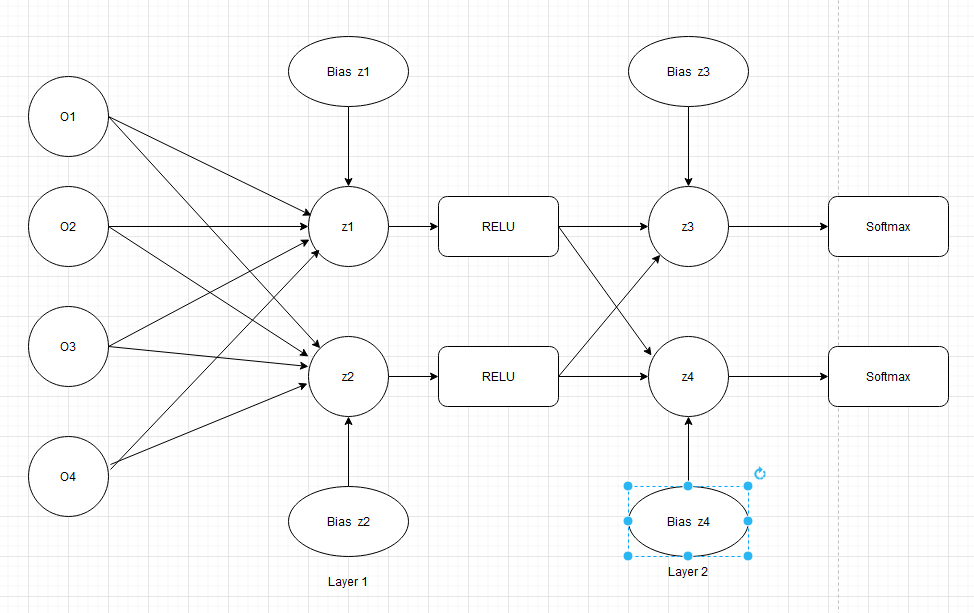

In [20]:
class ParticleSwarmOptimisation_GMM2(object):
    
    def __init__(self, fitnessFunction,policy, bounds, numParticles, omega, v, phiL, phiG):
        self.bestGlobalFitness = -np.inf              
        self.bestGlobalPos = []     
        self.fitnessFunction = fitnessFunction
        self.policy = policy
        self.bounds = bounds 
        self.swarm = [] #Create swarm
        for i in range(numParticles):
            self.swarm.append(Particle_2(bounds, omega, v, phiL, phiG))

    def maxamise(self, maxIterations, target):
        GlobalFitness = -np.inf              
        GlobalPos = []                
        #Optimisation loop
        for i in range(1, maxIterations):
            #Evaluate each particles fitness
            for p in self.swarm:
                fitness = p.evaluate(self.fitnessFunction)
                #Determine if current particle is new global best
                if fitness > self.bestGlobalFitness:
                    self.bestGlobalPos = p.bestPos.copy()
                    self.bestGlobalFitness = p.bestFitness
            #Update velocity and positions
            for p in self.swarm:
                p.updateVelocity(self.bestGlobalPos)
                p.updatePosition(self.bounds)     
            #Resample best to see if environment is solved
            Fitness = self.fitnessFunction(self.bestGlobalPos, 100)
            print('Iteration: ' + str(i) + ' Global best: ' + str(Fitness))
            if Fitness > target:
                return i
        return i #failed to solve
    
    def predict(self,state):
        pos = np.reshape(self.bestGlobalPos, (8,2))
        prob = self.policy(state, pos)
        return np.random.choice(2,p=prob) 

class Particle_2:
    def __init__(self, bounds, omega, v, phiL, phiG):
        self.bestFitness = -np.inf     
        self.bestPos = []
        self.omega, self.phiL, self.phiG  = omega, phiL, phiG

        self.position =  np.random.uniform(low=bounds[0], high=bounds[1], size=16)
        self.velocity = np.random.uniform(low=-v, high=v, size=16)

    # evaluate current fitness
    def evaluate(self, fitnessFunction):
        fitness = fitnessFunction(self.position, 25)
        #update best position
        if fitness > self.bestFitness:
            self.bestPos = self.position.copy()
            self.bestFitness = fitness
        else:
            #Re-evaluate best 
            self.bestFitness = fitnessFunction(self.bestPos, 25)
        return self.bestFitness
                    
    # update new particle velocity
    def updateVelocity(self, globalBest):
        velLocal= self.phiL * np.random.rand((len(self.bestPos))) * (self.bestPos - self.position)
        velGlobal = self.phiG * np.random.rand((len(self.bestPos))) * (globalBest - self.position)
        self.velocity = self.omega * self.velocity + velLocal + velGlobal

    # update the particle position 
    def updatePosition(self,bounds):  
        self.position = self.position + self.velocity            
        self.position[self.position < bounds[0]] = bounds[0]
        self.position[self.position > bounds[1]] = bounds[1]        
        
        
class GMMFitness_2(object):

    def __init__(self, machine):
        self.env = machine

    def policy(self, state, pos):
        state = np.append(state, 1) #need add bias
        z = state.dot(pos[0:5])   
        z = relu(z)
        z = np.append(z, 1)
        z = z.dot(pos[5:])
        exp = np.exp(z)
        return exp/np.sum(exp)

    def evaluate(self, pos, evaluationIterations):
        policy = np.reshape(pos, (8,2))
        rewardTotal = 0
        for i in range(evaluationIterations):
            state = self.env.reset()
            step = 0
            done = False
            while not done:
                step += 1
                probs = self.policy(state, policy)
                action = np.random.choice(2,p=probs)
                state, reward, done, _ = self.env.step(action)
                rewardTotal += reward

        return rewardTotal  / evaluationIterations

In [150]:
GMM_2 = GMMFitness_2(env)

weightSpaceBounds = 10
numberOfParticles = 50
momentum = 0.7
initialVelocityBounds = 0.3
localWeight = 1.8
globalWeight = 3

p = [weightSpaceBounds, numberOfParticles, momentum, initialVelocityBounds, localWeight, globalWeight]

timeTotal = 0
iterationTotal = 0
for i in range(1, 6):
    start = time.time()
    solver = ParticleSwarmOptimisation_GMM2(GMM_2.evaluate,GMM_2.policy,(-p[0],p[0]), p[1], p[2], p[3], p[4], p[5])
    k = solver.maxamise(10, 30000)
    iterationTotal += k
    end = time.time() - start
    print('Trail ' + str(i) + ' solved in ' + str(k) + ' iterations and ' + "{:.1f}".format(end) + ' seconds.')
    timeTotal += end
print('Solved in an average of ' + str(iterationTotal/i) + ' iterations, with an average of ' + "{:.1f}".format(timeTotal /i) + ' seconds per trail.')

Iteration: 1 Global best: 18554.0
Iteration: 2 Global best: 25936.0
Iteration: 3 Global best: 19395.0
Iteration: 4 Global best: 23574.0
Iteration: 5 Global best: 29473.0
Iteration: 6 Global best: 23032.0
Iteration: 7 Global best: 29585.0
Iteration: 8 Global best: 22846.0
Iteration: 9 Global best: 22486.0
Trail 1 solved in 9 iterations and 1248.1 seconds.
Iteration: 1 Global best: 25790.0
Iteration: 2 Global best: 22938.0
Iteration: 3 Global best: 25224.0
Iteration: 4 Global best: 24529.0
Iteration: 5 Global best: 23724.0
Iteration: 6 Global best: 26615.0
Iteration: 7 Global best: 26928.0
Iteration: 8 Global best: 25901.0
Iteration: 9 Global best: 25670.0
Trail 2 solved in 9 iterations and 1257.6 seconds.
Iteration: 1 Global best: 20953.0
Iteration: 2 Global best: 21445.0
Iteration: 3 Global best: 27332.0
Iteration: 4 Global best: 26243.0
Iteration: 5 Global best: 27184.0
Iteration: 6 Global best: 24236.0
Iteration: 7 Global best: 21874.0
Iteration: 8 Global best: 26220.0
Iteration: 9 G

In [131]:
state = env.reset()


In [142]:
env.step(0)
env.state

3

In [146]:
for _ in range(10):
    s = env.sensor()
    action = solver.predict(s)
    print(f"Action: {action}, State: {env.state}")

Action: 0, State: 3
Action: 1, State: 3
Action: 0, State: 3
Action: 1, State: 3
Action: 1, State: 3
Action: 1, State: 3
Action: 1, State: 3
Action: 1, State: 3
Action: 0, State: 3
Action: 0, State: 3


In [148]:
np.savetxt('weights_3.txt', solver.bestGlobalPos, delimiter=',')

In [154]:
env.reset()
rewards = 0

for _ in range(100):
    s = env.sensor()
    action = solver.predict(s)
    state = env.state
    _, reward, done, _ = env.step(action)
    rewards+= reward
    print(f"Action:{action}, State:{state}, Cumulative reward: {rewards}")

Action:0, State:0, Cumulative reward: 1000
Action:0, State:0, Cumulative reward: 2000
Action:1, State:0, Cumulative reward: 2000
Action:0, State:0, Cumulative reward: 2900
Action:1, State:1, Cumulative reward: 2900
Action:1, State:0, Cumulative reward: 2400
Action:0, State:0, Cumulative reward: 3300
Action:1, State:1, Cumulative reward: 3300
Action:0, State:0, Cumulative reward: 4300
Action:0, State:0, Cumulative reward: 5300
Action:0, State:0, Cumulative reward: 6300
Action:0, State:0, Cumulative reward: 7300
Action:1, State:0, Cumulative reward: 7300
Action:1, State:0, Cumulative reward: 7300
Action:1, State:0, Cumulative reward: 6800
Action:1, State:0, Cumulative reward: 7300
Action:0, State:0, Cumulative reward: 8300
Action:0, State:0, Cumulative reward: 9300
Action:0, State:0, Cumulative reward: 10200
Action:0, State:1, Cumulative reward: 11000
Action:1, State:2, Cumulative reward: 8900
Action:0, State:1, Cumulative reward: 9800
Action:0, State:1, Cumulative reward: 10600
Action:1